In [249]:
%load_ext autoreload
%autoreload 2
import pickle
import numpy as np
from collections import namedtuple, defaultdict
from paper_sims_util import MCC
from running_wrappers import get_loaders
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
LOADERS = get_loaders()
AlgoParams = namedtuple('AlgoParams', 'stability_samples M pi')
GraphParams = namedtuple('GraphParams', 'N eta p d ratios')
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [227]:
from paper_sims_util import GET_GRAPHS
np.set_printoptions(precision=3)
GET_GRAPHS()['chain'](5)

array([[ 5.263e+00, -4.737e+00,  0.000e+00, -2.431e-15,  2.828e-15],
       [-4.737e+00,  9.526e+00, -4.737e+00,  4.675e-15, -2.746e-15],
       [-1.063e-15, -4.737e+00,  9.526e+00, -4.737e+00,  1.753e-15],
       [-2.402e-15,  4.840e-15, -4.737e+00,  9.526e+00, -4.737e+00],
       [ 2.539e-15, -2.780e-15,  1.858e-15, -4.737e+00,  5.263e+00]])

In [288]:
run_name = 'server_p_50'
run_ids = range(5)
with open("{}_algo_params.pkl".format(run_name), 'rb') as f:
    algo_params = pickle.load(f)
with open("{}_graph_params_dict.pkl".format(run_name), 'rb') as f:
    graph_params_dict = pickle.load(f)
graph_params_dict = {
    'chain': GraphParams(p=20, N=[20, 25, 30, 35, 40], eta=1, ratios=None, d=None), #p, N, eta
    'star': GraphParams(p=20, d=[10, 15, 20, 25, 30], N=50, eta=1, ratios=None), #p, d, N, eta
    'random': GraphParams(p=20, d=0.01, ratios=[r/500. for r in [300, 375, 500, 750, 1000]], eta=1, N=None), #p, d, ratio over 500, eta
    'grid_3D': GraphParams(p=2, ratios=[0.5, 0.85, 1., 1.25, 1.5, 2], eta=2, N=None, d=None), #p, ratio over 524, eta
    'grid': GraphParams(p=7, ratios=[0.5, 0.85, 1., 1.25, 1.5, 2], eta=2, N=None, d=None) #p, ratio over 529, eta
}

In [289]:
def get_points(loaded_data):
    points = defaultdict(lambda: defaultdict(list))
    for x_label, trials in loaded_data.items(): #x_;
        #print(x_label)
        for trial in trials:
            #print(type(trial))
#             if type(trial) != dict:
#                 continue
            #print(x_label)
            #print(trials.keys())
            omega = trial[0]
            #print(np.sum(omega))
            results = trial[1]
            for algo_name, algo_results in results.items():
                omega_hat = algo_results[0]
                #print(algo_name, np.sum(omega_hat))
                algo_mcc = MCC(omega_hat, omega)
                points[algo_name][x_label].append(algo_mcc)
    return points

In [290]:
def plot_lines(d):
    lines = defaultdict(list)
    x_labels = list(next(iter(d.values())).keys())
    for algo_name, x_label_to_trials in d.items():
        for x_label in x_labels:
            trial_MCCs = x_label_to_trials[x_label]
            lines[algo_name].append(np.mean(trial_MCCs))
    return x_labels, lines

In [291]:
def plot(graph_type, ret = False):
    loaded_data = LOADERS[graph_type](graph_params_dict[graph_type], 
                                  algo_params, 
                                  run_name,
                                  run_ids)
    points = get_points(loaded_data)
    lines = plot_lines(points)
    if ret:
        return points, lines
    for algo, line in lines[1].items():
        plt.plot(lines[0], line, label=algo)
    plt.title(graph_type)
    plt.legend()
    plt.show()

In [292]:
points, lines = plot('grid', True)

In [293]:
for algo_name in points.keys():
    print(algo_name, points[algo_name])

our defaultdict(<class 'list'>, {24: [0.33360032042726484, 0.1371255585345737, 0.21684020827772216, 0.2612622724270121, 0.17013616341790508], 41: [0.2064212834827546, 0.26924515236881036, 0.25802413141750924, 0.3763434209987755, 0.32533965910699764], 49: [0.40008236107434014, 0.3320690212548661, 0.4726898017013896, 0.37395160051223664, 0.4127110353223613]})
SH defaultdict(<class 'list'>, {24: [0.18234056553995937, 0.2356015974567392, 0.21063855459671635, -0.011447463651820707, 0.06868478191092424], 41: [0.6215145657813617, 0.48559824335184854, 0.5313785491223932, 0.4954726603452494, 0.5414351022802625], 49: [0.6588587886180101, 0.6852762393583152, 0.5831366986652382, 0.6314847631851218, 0.7108448166490986]})
glasso defaultdict(<class 'list'>, {24: [0, 0, 0, 0, 0], 41: [0, 0, 0.39764076677128596, 0, 0.18234056553995937], 49: [0, 0, 0.21063855459671635, 0.2817519035927293, 0.3003801157526146]})
nbsel defaultdict(<class 'list'>, {24: [0.315051563809044, 0.1900687717983427, 0.3272441776453

defaultdict(<function __main__.get_points.<locals>.<lambda>()>,
            {'our': defaultdict(list,
                         {24: [0.33360032042726484,
                           0.1371255585345737,
                           0.21684020827772216,
                           0.2612622724270121,
                           0.17013616341790508],
                          41: [0.2064212834827546,
                           0.26924515236881036,
                           0.25802413141750924,
                           0.3763434209987755,
                           0.32533965910699764],
                          49: [0.40008236107434014,
                           0.3320690212548661,
                           0.4726898017013896,
                           0.37395160051223664,
                           0.4127110353223613]}),
             'SH': defaultdict(list,
                         {24: [0.18234056553995937,
                           0.2356015974567392,
                           0.210

In [284]:
lines

([4, 7, 9],
 defaultdict(list,
             {'our': [0.22379290461689555,
               0.2870747294749695,
               0.39830076397303876],
              'SH': [0.1371636071705037,
               0.535079824176223,
               0.6539202612951568],
              'glasso': [0.0, 0.11599626646224906, 0.15855411478841203],
              'nbsel': [0.2646394745521186,
               0.47153115812898205,
               0.5134810747270112],
              'anand': [0.20677089750389444,
               0.4950129401928257,
               0.5970413604417609]}))

In [285]:
tups = []
for algo_name in lines[1].keys():
    for t in zip(lines[0], lines[1][algo_name]):
        tups.append((algo_name,) + t)

In [286]:
df = pd.DataFrame(tups, columns = ['Algorithm', 'N', 'MCC'])

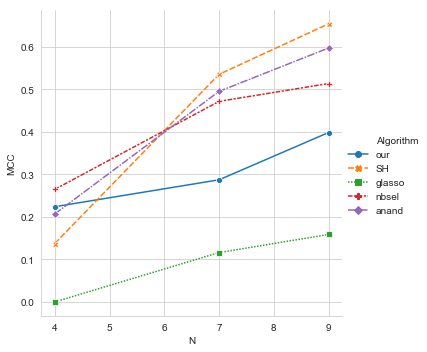

In [287]:
sns.set_style('whitegrid')
g = sns.relplot(x='N', y='MCC', data = df, kind='line', 
            hue='Algorithm',
            style='Algorithm',
            markers = True)

In [272]:
g.set_xticklabels([lines[0]])

In [273]:
sns.plt.show()

AttributeError: module 'seaborn' has no attribute 'plt'

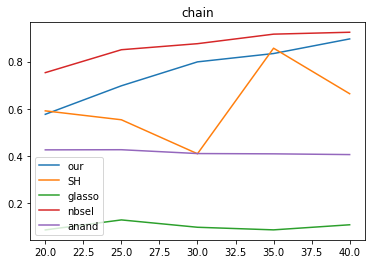

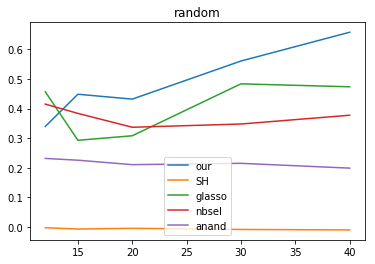

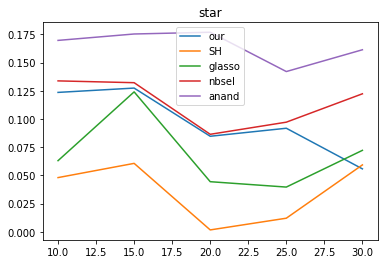

In [214]:
for graph_type in ['chain', 'random', 'star']:
    plot(graph_type)

In [241]:
sns.load_dataset('tips')

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
5,25.29,4.71,Male,No,Sun,Dinner,4
6,8.77,2.00,Male,No,Sun,Dinner,2
7,26.88,3.12,Male,No,Sun,Dinner,4
8,15.04,1.96,Male,No,Sun,Dinner,2
9,14.78,3.23,Male,No,Sun,Dinner,2
